In [1]:
# This notebook contains Lasso, SVR, and Decision Tree Models

### Import modules

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

### Data preprocessing from Anar's notebook

In [3]:
fn = "DATASET_for_Python.xlsx"
Raw_raw = pd.read_excel(fn, sheet_name = 'Raw')
PE_raw = pd.read_excel(fn, sheet_name = 'PE')
SFE_raw = pd.read_excel(fn, sheet_name = 'SFE')
Etc_raw = pd.read_excel(fn, sheet_name = 'Etc')

In [4]:
Raw_raw.usecols = ['Date','Month','Temp_C','TPRaw_Mass_kg.d', 'SPRaw_Mass_kg.d','FerricRaw_Mass_kg.d']
Raw = Raw_raw.loc[:,Raw_raw.usecols]
PE_raw.usecols = ['PE Flow_MGD', 'BODPE_Mass_kg.d', 'VSSPE_Mass_kg.d', 'SPPE_Mass_kg.d','f.TPPE_Mass_kg.d']
PE = PE_raw.loc[:,PE_raw.usecols]
# SFE
SFE_raw.usecols = ['SPSFE_Mass_kg.d', 'TPSFE_Mass_kg.d', 'TSSSFE_Mass_kg.d']
SFE = SFE_raw.loc[:,SFE_raw.usecols]
SFE.head(5)
# Etc.
Etc_raw.usecols = ['RAS_FlowMGD', 'MVLSSmg.l','SRT_PredDays', 'Sludge_Blanket_Depth_ft']
Etc = Etc_raw.loc[:,Etc_raw.usecols]
Etc.head(5)

C:\Users\14407\AppData\Local\Temp/ipykernel_11956/3739660384.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Raw_raw.usecols = ['Date','Month','Temp_C','TPRaw_Mass_kg.d', 'SPRaw_Mass_kg.d','FerricRaw_Mass_kg.d']
C:\Users\14407\AppData\Local\Temp/ipykernel_11956/3739660384.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  PE_raw.usecols = ['PE Flow_MGD', 'BODPE_Mass_kg.d', 'VSSPE_Mass_kg.d', 'SPPE_Mass_kg.d','f.TPPE_Mass_kg.d']
C:\Users\14407\AppData\Local\Temp/ipykernel_11956/3739660384.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  SFE_raw.usecols = ['SPSFE_Mass_kg.d', 'TPSFE_Mass_kg.d', 'TSSSFE_Mass_kg.d']
C:\Users\14407\A

,RAS_FlowMGD,MVLSSmg.l,SRT_PredDays,Sludge_Blanket_Depth_ft
0,155.426097,1606.666667,2.721281,73.60
1,154.770060,1768.333333,2.927742,75.24
2,155.021861,1723.000000,2.781791,78.20
3,160.281722,1834.666667,7.063988,82.80
4,158.443042,1769.666667,2.638802,82.80


In [5]:
df = pd.concat([Raw,PE,SFE,Etc], axis=1)
df['Date'] = pd.to_datetime(df['Date']).dt.date #remove time from datetime
df = df.set_index('Date') # set index with Date
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3165 entries, 2013-01-01 to 2021-08-31
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    3165 non-null   int64  
 1   Temp_C                   3165 non-null   float64
 2   TPRaw_Mass_kg.d          3157 non-null   float64
 3   SPRaw_Mass_kg.d          3157 non-null   float64
 4   FerricRaw_Mass_kg.d      3104 non-null   float64
 5   PE Flow_MGD              3165 non-null   float64
 6   BODPE_Mass_kg.d          3159 non-null   float64
 7   VSSPE_Mass_kg.d          3162 non-null   float64
 8   SPPE_Mass_kg.d           3157 non-null   float64
 9   f.TPPE_Mass_kg.d         3165 non-null   float64
 10  SPSFE_Mass_kg.d          3165 non-null   float64
 11  TPSFE_Mass_kg.d          3165 non-null   float64
 12  TSSSFE_Mass_kg.d         3165 non-null   float64
 13  RAS_FlowMGD              3165 non-null   float64
 14  MVLSSmg.l     

In [6]:
df.columns = ["Month", "Temp", "Raw_TP", "Raw_SP", "Ferric", "PE_flow", "PE_BOD", "PE_VSS", "PE_SP", "PE_TP", "SFE_SP", "SFE_TP", "SFE_TSS", "RAS_flow", "MLVSS", "SRT", "SLBk"]
df['week_day'] = np.arange(2,3167)%7

In [7]:
df['Mn'] = (df['week_day'].values == 1)+np.zeros(3165)
df['Ts'] = (df['week_day'].values == 2)+np.zeros(3165)
df['Wed'] = (df['week_day'].values == 3)+np.zeros(3165)
df['Th'] = (df['week_day'].values == 4)+np.zeros(3165)
df['Fr'] = (df['week_day'].values == 5)+np.zeros(3165)
df['Sat'] = (df['week_day'].values == 6)+np.zeros(3165)
df['Sun'] = (df['week_day'].values == 0)+np.zeros(3165)

In [8]:
df['Winter'] = ((df['Month'] > 11)  | (df["Month"]<3)) + np.zeros(3165)
df['Summer'] = ((df['Month'] > 5)  & (df["Month"]<9)) + np.zeros(3165)
df['Fall'] = ((df['Month'] > 8)  & (df["Month"]<12)) + np.zeros(3165)
df['Spring'] = ((df['Month'] > 2)  & (df["Month"]<6)) + np.zeros(3165)

In [9]:
df=df.fillna(df.mean(axis=0)) # Mean to NaN
#df=df.fillna(method="ffill", axis=0) #fill with previous value
#df.where(pd.notnull(df), df.mean(), axis='columns')
print(df.info())    

<class 'pandas.core.frame.DataFrame'>
Index: 3165 entries, 2013-01-01 to 2021-08-31
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     3165 non-null   int64  
 1   Temp      3165 non-null   float64
 2   Raw_TP    3165 non-null   float64
 3   Raw_SP    3165 non-null   float64
 4   Ferric    3165 non-null   float64
 5   PE_flow   3165 non-null   float64
 6   PE_BOD    3165 non-null   float64
 7   PE_VSS    3165 non-null   float64
 8   PE_SP     3165 non-null   float64
 9   PE_TP     3165 non-null   float64
 10  SFE_SP    3165 non-null   float64
 11  SFE_TP    3165 non-null   float64
 12  SFE_TSS   3165 non-null   float64
 13  RAS_flow  3165 non-null   float64
 14  MLVSS     3165 non-null   float64
 15  SRT       3165 non-null   float64
 16  SLBk      3165 non-null   float64
 17  week_day  3165 non-null   int32  
 18  Mn        3165 non-null   float64
 19  Ts        3165 non-null   float64
 20  Wed       3165 non-n

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled_df = min_max_scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)

In [11]:
# X = scaled_df.loc[:,['PE_TP','Temp', 'Raw_TP', 'Ferric', 'PE_flow', 'PE_BOD', 'SFE_TSS', 'MLVSS', 'SRT', 'SLBk', 'Winter', 'Fall', 'Summer', 'Spring', 'Mn', 'Ts', 'Wed', 'Th',
#                      'Fr', 'Sat', 'Sun']]
X = scaled_df.loc[:,['PE_TP','Temp', 'Raw_TP', 'Ferric', 'PE_flow', 'PE_BOD', 'SFE_TSS', 'MLVSS', 'SRT', 'SLBk']]
y = scaled_df.loc[:,'SFE_TP']

In [12]:
unscaled_y = df.loc[:,'SFE_TP']

In [13]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, unscaled_y, test_size=0.25, random_state=113021)
X_train, X_test, y_train, y_test = np.array(X_train_df),  np.array(X_test_df),  np.array(y_train_df),  np.array(y_test_df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2373, 10) (792, 10) (2373,) (792,)


### Lasso

In [14]:
# K Fold cross validation for alpha hyperparameter
alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 1]

kf = KFold(n_splits=5, random_state=113021, shuffle=True)
kf.get_n_splits(X_train)

avg_mses = []
for alph in alphas:
    mses = []
    for train_i, test_i in kf.split(X_train):
        x_in, x_v = X_train[train_i], X_train[test_i]
        y_in, y_v = y_train[train_i], y_train[test_i]
            
        clf = linear_model.Lasso(alpha=alph)
        clf.fit(x_in, y_in)
            
        preds = clf.predict(x_v)
        mse = mean_squared_error(y_v, preds)
        mses.append(mse)
        
    mse_avg = sum(mses) / len(mses)
    avg_mses.append(mse_avg)

print(avg_mses)
min_val = min(avg_mses)
min_i = avg_mses.index(min_val)
print("Minimum MSE:", round(min_val, 2), "when alpha =", alphas[min_i])

[107945.83817089626, 107945.03522708503, 107959.85181720073, 108106.84647555074, 108681.19814659492, 109767.03401886814]
Minimum MSE: 107945.04 when alpha = 0.05


In [15]:
# Determined best value of alpha is 0.05
lasso_mod = linear_model.Lasso(alpha=0.05)
lasso_mod.fit(X_train, y_train)
print(lasso_mod.coef_)
print(X_train_df.columns[lasso_mod.coef_ == 0])

[1669.28294922   28.1618774   180.32117859  464.55915239 -215.52692811
   39.10332879 4393.53177644  109.65087905  814.90793708 -503.63189688]
Index([], dtype='object')


In [16]:
preds = lasso_mod.predict(X_test)
print("Lasso MSE:", mean_squared_error(y_test, preds))

Lasso MSE: 119880.62271180593


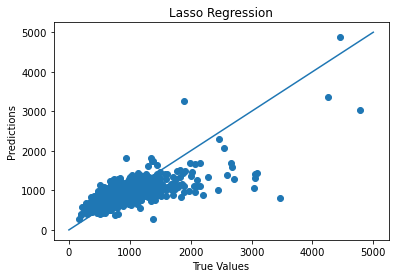

In [17]:
plt.scatter(y_test, preds)
x = [0, 5000]
y = [0, 5000]
plt.plot(x, y)
plt.title('Lasso Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### SVR

In [18]:
reg_range = np.logspace(-1,1,3)     # Regularization paramters
kpara_range = np.logspace(-2, 0, 3) # Kernel parameters 

In [19]:
# K fold cross validation for regularization parameter and kernel parameter
for C in reg_range:
    for gamma in kpara_range:
        mses = []
        for train_i, test_i in kf.split(X_train):
            x_in, x_v = X_train[train_i], X_train[test_i]
            y_in, y_v = y_train[train_i], y_train[test_i]

            svr = SVR(kernel="rbf", C=C, gamma=gamma).fit(x_in, y_in)
            preds = svr.predict(x_v)
            mse = mean_squared_error(y_v, preds)
            mses.append(mse)
                  
        svr_avg = sum(mses) / len(mses)
        print("C: ", C, "Gamma: ", gamma, "SVR Avg. MSE: ", svr_avg)

C:  0.1 Gamma:  0.01 SVR Avg. MSE:  201511.59775674096
C:  0.1 Gamma:  0.1 SVR Avg. MSE:  201420.20093846048
C:  0.1 Gamma:  1.0 SVR Avg. MSE:  200759.51026542028
C:  1.0 Gamma:  0.01 SVR Avg. MSE:  201415.41639839928
C:  1.0 Gamma:  0.1 SVR Avg. MSE:  200362.89250818122
C:  1.0 Gamma:  1.0 SVR Avg. MSE:  193499.7884634745
C:  10.0 Gamma:  0.01 SVR Avg. MSE:  200331.98880303183
C:  10.0 Gamma:  0.1 SVR Avg. MSE:  190357.02670365368
C:  10.0 Gamma:  1.0 SVR Avg. MSE:  160305.20427525864


In [20]:
# Lowest MSE identified with C=10 and gamma=1
svr = SVR(kernel="rbf", C=10, gamma=1).fit(X_train, y_train)
preds = svr.predict(X_test)
print("SVR MSE:", mean_squared_error(y_test, preds))

SVR MSE: 196593.42782434556


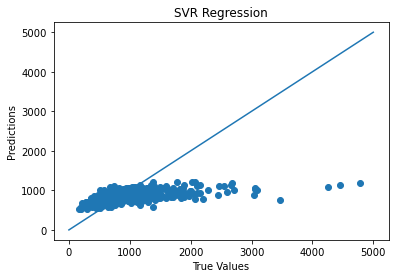

In [21]:
plt.scatter(y_test, preds)
x_vals = [0, 5000]
y_vals = [0, 5000]
plt.plot(x_vals, y_vals)
plt.title('SVR Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Regression Tree

In [22]:
# K fold cross validation for max depth
max_depths = [1, 5, 10, 25, 50, 100]

for d in max_depths:
    mses = []
    for train_i, test_i in kf.split(X_train):
        x_in, x_v = X_train[train_i], X_train[test_i]
        y_in, y_v = y_train[train_i], y_train[test_i]

        regressor = DecisionTreeRegressor(max_depth = d, random_state=113021)
        regressor.fit(x_in, y_in)
        preds = regressor.predict(x_v)
        mse = mean_squared_error(y_v, preds)
        mses.append(mse)
            
        
    rt_avg = sum(mses) / len(mses)
    print("Depth: ", d, "Regression Tree Avg. MSE: ", rt_avg)

Depth:  1 Regression Tree Avg. MSE:  166386.3516006332
Depth:  5 Regression Tree Avg. MSE:  132655.90837771734
Depth:  10 Regression Tree Avg. MSE:  165352.6822031005
Depth:  25 Regression Tree Avg. MSE:  191630.09188345895
Depth:  50 Regression Tree Avg. MSE:  190922.76210258607
Depth:  100 Regression Tree Avg. MSE:  190922.76210258607


In [23]:
# Lowest MSE identified with max_depth = 5
regressor = DecisionTreeRegressor(max_depth = 5, random_state=113021)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
print("Decision tree MSE:", mean_squared_error(y_test, preds))

Decision tree MSE: 154184.76947349912


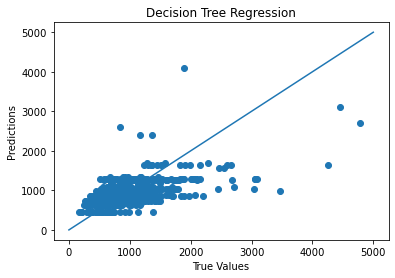

In [24]:
plt.scatter(y_test, preds)
x_vals = [0, 5000]
y_vals = [0, 5000]
plt.plot(x_vals, y_vals)
plt.title('Decision Tree Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()